# 概要
本ノートブックは、kmeans++のアルゴリズムについてなんとなく理解をするためのノートブックです。

# Paragraph
1. kmeans++の前にkmeansを復習する
2. kmeans++って何か
3. kmeansとkmeans++の違い、利点を理解する

# 1. kmeans++の前にkmeansを復習する
## 1-1. 階層クラスター分析と非階層クラスター分析
クラスター分析には、階層クラスター分析と非階層クラスター分析の2つがあります。

### 階層クラスター分析
階層クラスター分析は、もっとも似ている組み合わせから順番にまとまり(クラスター)にしていく方法です。  
階層クラスター分析の例としては、
- ウォード法
- 最長距離法
- 最短距離法
- 群平均法
などがあります。(各手法についての説明は省く)

階層クラスター分析の利点としては、
- 近いものから順番にクラスター分けしていくので、あらかじめクラスター数を決める必要がない
- ただ分類するだけでなく、結果として出力される樹形図から、分類の過程でできるクラスターがどのように結合されていくのかを一つ一つ確認できるので、後からクラスター数を決めるのも容易

そして、階層クラスター分析の欠点は、
- 分類の対象が非常に多くなると、計算量が多くなり実行が困難になる
- 分類の対象が多くなると系統図が巨大になり、結果が不明瞭になる

上記の欠点から、非常に多くのデータを対象とするクラスター分析では、非階層的クラスター分析を行うのが一般的.

### 非階層クラスター分析
非階層クラスター分析は、異なる性質のものが混ざり合った集団から、お互いに似た性質を持つものを集めクラスターを作る方法です。  
非階層クラスター分析の手法の一つがkmeansです。

kmeansは、ビッグデータをクラスターに分けることができますが以下のような欠点があります。
- 最適なクラスター数を自動で計算できないので分析者が試行錯誤をしてクラスター数を決定する必要がある
- 「初期値依存性」という問題点(後述)

ただ、現在ではそれぞれの欠点を埋めるためのアルゴリズムが開発されているみたいです。
- クラスター数を決定する必要がある問題　-> `x-means`
- 「初期値依存性」 -> `k-means++`

## 1-2. kmeansとは
kmeansの名称は **「クラスターの平均（means）を用い、あらかじめ決められたクラスター数「k」個に分類する」** に由しています。

数式で書くと下記のように最適化問題を解くアルゴリズムとなる。
$$
    \mathrm{arg min}_{c_1...c_k}f = \sum_{i=1}^{n}\underset{j}{\mathrm{min}}||x_i-c_j||^{2}
$$

kmeansは以下のような流れとなっている。データの数を$n$、クラスタの数を$k$とするとき、
1. クラスタ数である$k$を決める
2. セントロイドとして$k$個の特徴量ベクトルを無作為に決めて、特徴量ベクトル空間に置く
3. 各データ$x$と各セントロイド$c$との距離を計算して各データに最も近いセントロイドを割り当てる
4. 各セントロイドについてデータの特徴量ベクトルの平均を算出し、これらの平均特徴量ベクトルが新たなセントロイドとなる
5. 再び、各データと新たなセントロイドとの距離を計算し、データに対するセントロイドの割り当てを修正し、割り当てに変更がなくなるまで繰り返す

## 1-3. 実際にkmeansを実装する

実務で使う時には`sklearn.cluster.KMeans`を使えば一瞬だが、芸がないので最初はnumpyで実装していく

In [35]:
import numpy as np
import itertools

class KMeans:
    def __init__(self, n_clusters, max_iter=1000, random_seed=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = np.random.RandomState(random_seed)

    def fit(self, X):
        # 指定したクラスター数分のラベルを繰り返し作成するジェネレータを生成(0,1,2,0,1,2...みたいな)
        cycle = itertools.cycle(range(self.n_clusters))
        # 各データポイントに対してクラスタのラベルをランダムに割り振る
        self.labels_ = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype=np.int64)
        print("labels_ is ", self.labels_)
        self.random_state.shuffle(self.labels_)
        labels_prev = np.zeros(X.shape[0])
        print("labels_prev is ", labels_prev)
        count = 0
        self.cluster_centers_ = np.zeros((self.n_clusters, X.shape[1]))
        print("cluster_centers_ before while is ", self.cluster_centers_)

        # 各データポイントが属しているクラスターが変化しなくなった、又は一定回数の繰り返しを越した場合は終了する
        while (not (self.labels_ == labels_prev).all() and count < self.max_iter):
            # その時点での各クラスターの重心を計算する
            for i in range(self.n_clusters):
                XX = X[self.labels_ == i, :]
                self.cluster_centers_[i, :] = XX.mean(axis = 0)
            # 各ポイントと各クラスターの重心間の距離を総当たりで計算する
            dist = ((X[:, :, np.newaxis] - self.cluster_centers_.T[np.newaxis, :, :]) ** 2).sum(axis=1)
            # 1つ前のクラスターラベルを覚えておく。1つ前のラベルとラベルが変化しなければプログラムは終了する
            labels_prev = self.labels_
            # 再計算した結果、最も距離の近いクラスターのラベルを割り振る
            self.labels_ = dist.argmin(axis=1)

            if count < 1:
                print(f"In count {count}, XX is ", XX)
                print(f"In count {count}, cluster_center_ is ", self.cluster_centers_)
                print(f"In count {count}, dist is ", dist)
                print(f"In count {count}, labels_prev is ", labels_prev)
                print(f"In count {count}, labels_ is ", self.labels_)
            count += 1


    def predict(self, X):
        dist = ((X[:, :, np.newaxis] - self.cluster_centers_.T[np.newaxis, :, :]) ** 2).sum(axis=1)
        labels = dist.argmin(axis=1)
        return labels


In [36]:
import matplotlib.pyplot as plt

np.random.seed(0)
points1 = np.random.randn(80, 2)
points2 = np.random.randn(80, 2) + np.array([4, 0])
points3 = np.random.randn(80, 2) + np.array([5, 8])

points = np.r_[points1, points2, points3]
np.random.shuffle(points)

model = KMeans(3)
model.fit(points)

print(model.labels_)

labels_ is  [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1
 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2
 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1
 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2
 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2]
labels_prev is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

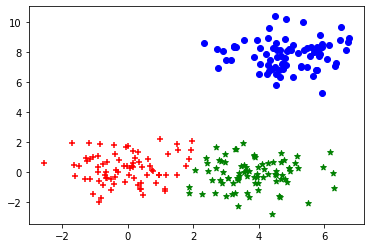

In [37]:
markers = ["+", "*", "o"]
color = ["r", "g", "b"]

for i in range(3):
    p = points[model.labels_ == i, :]
    plt.scatter(p[:, 0], p[:, 1], marker=markers[i], color= color[i])

plt.show()

# 参考文献
- web
  - [クラスター分析の手法②(階層クラスター分析) -ALBERT](https://www.albert2005.co.jp/knowledge/data_mining/cluster/hierarchical_clustering)  
  - [クラスター分析の手法③(非階層クラスター分析) -ALBERT](https://www.albert2005.co.jp/knowledge/data_mining/cluster/non-hierarchical_clustering)
- book
  - [機械学習100+ページエッセンス -impress top gearシリーズ](https://amzn.to/3nEtLIy)